## Análise a fim de orientar o tipo do próximo filme a ser desenvolvido em Hollywood

ML com aprendizagem em regressão, pois analisaremos dados passados e atuais, para decisão futura.

## Importar Bibliotecas e Carregar os Dados

In [763]:
import pandas as pd
import numpy as np
from empiricaldist import Cdf, Pmf


# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [764]:
series = pd.read_csv("./series_imdb.csv")

series.head()

,id,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 2 Exploração e formatação de dados

### 2.1 Exploração

In [765]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Nota-se a coluna responsável pelo ID, não identificada.

Também é possível ver que as colunas Runtime, Released_year e Gross estão sendo carregadas com tipo não correspondente.

- Runtime deveria ser int64 mas está como object, provavelmente por incluir "min" de minutos.
- Released_year como são apenas números deveria ser carregado, também, como int64. 
- Gross, em pesquisa, é o faturamento apenas no EUA e Canadá, portanto é um valor que representa dólares, assim deveria ser carregado como int64 por não considerar flutuação de centavos. 

In [766]:
series.isnull().sum()

id                 0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Tabelas como id, Series_Title e Overview possuem baixa influência, portanto não são necessárias. Series_title é apenas o título do filme e Overview se torna inútil com a existência da coluna Genre.

Além disso, existem poucas linhas e colunas com valores nulos, portanto é possível limpá-los.

In [767]:
series['Certificate'].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

É possível destacar a falta de especifidade devido a diferença de certificações por países, como é possível destacar em artigo publicado pelo IMDB - https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpms_helpart_inline&utm_source=chatgpt.com#canada

Para resolver o problema é necessário adicionar uma coluna de severidade para a certificação, que ocorre de forma diferente para cada país mas possui a mesma lógica.

Com isso, é possível criar uma coluna com o nível de severidade em escala 
de 0-10, abrangindo categorias como 12 e 12+ com severidade 
igual a 3 e 4 (exemplo) e equivalências entre países.

Issues List
- Corrigir coluna "unnamed" para "id". (alteração é necessária ser feita no arquivo .csv para identificação na formatação)
- Limpar as colunas id, Series_Title e Overview
- Eliminar linhas com valores nulos.
- Corrigir os tipos das colunas Runtime, Released_year e Gross
- Adicionar nova coluna de severidade para a certificação.
- Converter as colunas para snake_case (boa prática)

### 2.2 Formatação dos dados

- Converter as colunas é um bom início

In [768]:
series.rename(lambda x: x.lower().strip().replace(" ", "_"), axis='columns', inplace=True)

series.columns

Index(['id', 'series_title', 'released_year', 'certificate', 'runtime',
       'genre', 'imdb_rating', 'overview', 'meta_score', 'director', 'star1',
       'star2', 'star3', 'star4', 'no_of_votes', 'gross'],
      dtype='object')

- Eliminar as linhas que possuem valores nulos

In [769]:
series = series.dropna()
series.isnull().sum()

id               0
series_title     0
released_year    0
certificate      0
runtime          0
genre            0
imdb_rating      0
overview         0
meta_score       0
director         0
star1            0
star2            0
star3            0
star4            0
no_of_votes      0
gross            0
dtype: int64

- Eliminar colunas desnecessárias

In [770]:
to_drop = ['id', 'series_title', 'overview']
series.drop(to_drop, axis='columns', inplace=True)

Afirmando o drop correto

In [771]:

assert series.columns.all() not in to_drop

- Corrigir os tipos das colunas Runtime, Released_year e Gross

Convertendo tipo do **Runtime** para "int64".

In [772]:
series['runtime'] = pd.to_numeric(series['runtime'].str.replace(' min', ''), errors='coerce').astype('Int64')

Confirmando tipo correto para a coluna

In [773]:
series.runtime.dtypes

Int64Dtype()

- Convertendo o tipo de **gross** para int64.

In [774]:
series['gross'] = pd.to_numeric(series['gross'].str.replace('$', '').str.replace(',', ''), errors='coerce').astype('Int64')

Confirmando

In [775]:
series.gross.dtypes

Int64Dtype()

- Convertendo o tipo de **released_year** para int64.

In [776]:
series['released_year'] = pd.to_numeric(series['released_year'], errors='coerce').astype('Int64')

Confirmando: 

In [777]:
series.released_year.dtypes

Int64Dtype()

- Última etapa é otimizar a coluna de certificações para nível de severidade 0-10

Começamos entendendo quais certificações devemos otimizar

In [778]:
series['certificate'].value_counts()

certificate
U           183
A           173
UA          142
R           131
PG-13        38
PG           19
G             9
Passed        9
Approved      6
TV-PG         1
U/A           1
GP            1
Name: count, dtype: int64

Baseado nas certificações do imdb anteriormente mencionada, podemos mapear numericamente.

In [779]:
mapeamento_severidade = {
    'G': 1,        # Audiência Geral
    'U': 1,        # Universal 
    'Passed': 2,   # Antigo sistema
    'Approved': 2, # Antigo sistema  
    'PG': 3,       # Parental Guidance
    'GP': 3,       # General/Parental
    'TV-PG': 4,    # TV Parental
    'PG-13': 5,    # 13+ anos
    'UA': 6,       # Unrestricted Adult
    'U/A': 6,      # Universal/Adult
    'R': 8,        # Restricted (mais severo)
    'A': 9         # Adults Only (máximo)
}

series['mapeamento_severidade'] = series['certificate'].map(mapeamento_severidade).astype('Int64')

Confirmando:

In [780]:
assert series['mapeamento_severidade'].isnull().sum() == 0

In [781]:
series.columns

Index(['released_year', 'certificate', 'runtime', 'genre', 'imdb_rating',
       'meta_score', 'director', 'star1', 'star2', 'star3', 'star4',
       'no_of_votes', 'gross', 'mapeamento_severidade'],
      dtype='object')

## 3. Univariate Exploration

### 3.1 Qual filme você recomendaria para uma pessoa que você não conhece?
Antes de recomendar um filme, preciso entender o gosto e momento atual da pessoa, podendo perguntar diretamente sobre o gênero, filmes recentes ou antigos, entre outros, ou indiretamente sobre os filmes favoritos dela, atores ou diretos prediletos, filmes mais longos ou curtos e etc, na qual é possível notar padrões. Além disso, pessoas possuem momentos diferentes, como por exemplo estar em um momento de extrema felicidade após uma conquista, ela pode gostar mais de comédia, mas se estiver enfrentando algum problema, mesmo gostando de dar risada, pode acabar não encontrando tanta graça. Então depende de quais informações eu conseguir extrair daquela pessoa e cruzar os dados, para enfim chegar em alguma escolha apropriada.

Voltando a análise, com os dados formatados e limpos, é possível analisar estatisticamente.

Podemos começar entendendo  algumas variáveis de sucesso como faturamento.

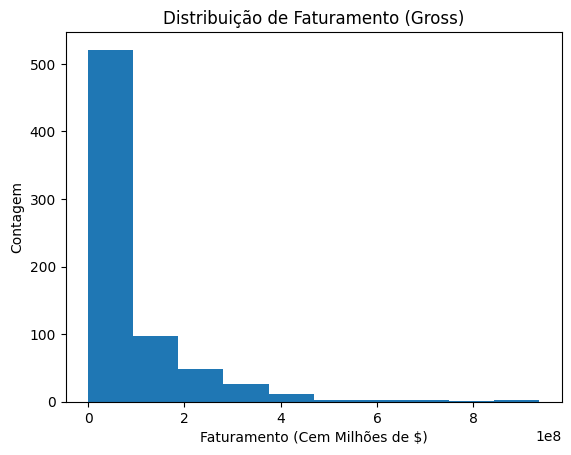

In [782]:
fig, ax = plt.subplots()

ax.hist(series['gross'], bins=10)

ax.set(title='Distribuição de Faturamento (Gross)',
             xlabel='Faturamento (Cem Milhões de $)',
             ylabel='Contagem')
plt.show();

Conclui-se que a vasta maioria dos filmes possuem faturamento menor que 200 milhões

Também é possível enxergar um ponto, acima de 200 Milhões, onde o filme se enquadra em bom resultado pela dificuldade de se alcançar este nível (levando em conta apenas faturamento, não lucro)

Criando especifidade, podemos aproximar dos filmes de maior faturamento

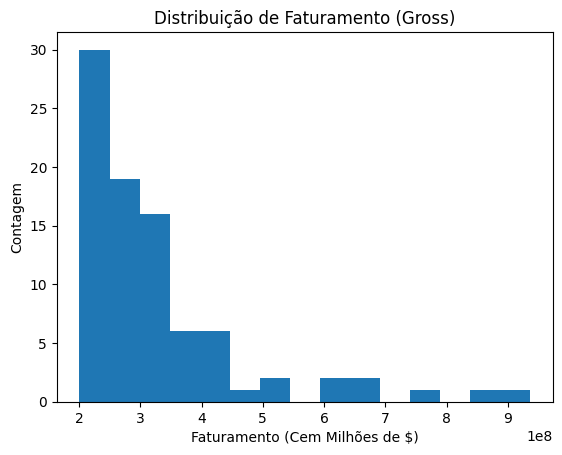

In [783]:
fig, ax = plt.subplots()

acima_200M = series[series['gross'] > 200000000]

ax.hist(acima_200M['gross'], bins=15)

ax.set(title='Distribuição de Faturamento (Gross)',
             xlabel='Faturamento (Cem Milhões de $)',
             ylabel='Contagem')
plt.show();

Quantificando:

In [784]:
acima_200M.shape

(87, 14)

Apenas 87 dos 1 Mil filmes, alcançaram esta prateleira.

Também é visível uma "barreira dos 500 Milhões", na qual sugere que o filme alcançou uma nova pratileira de sucesso.

Quantos filmes ultrapassaram essa barreira?:

Acima de 500 Milhões:

In [785]:
acima_500M = series[series['gross'] > 500000000]
acima_500M.shape

(9, 14)

De 1 Mil filmes, apenas 9 conseguem chegar ao patamar dos 500 Milhões 

Agora, analisando a distribuição do imdb_rating:

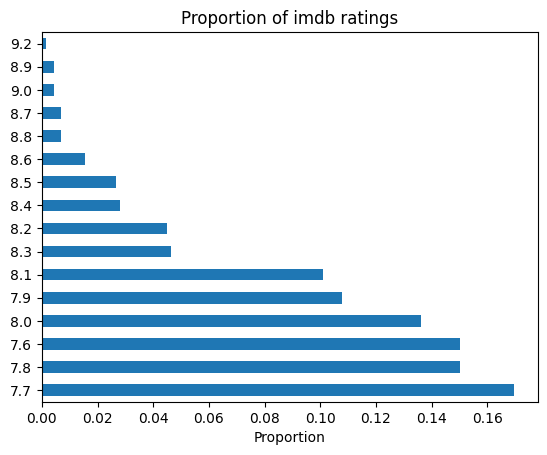

In [786]:
fig, ax = plt.subplots()

series['imdb_rating'].value_counts(normalize=True).plot.barh()

ax.set(title='Proportion of imdb ratings',
       xlabel='Proportion', ylabel='')
plt.show();

Neste gráfico também conseguimos enxergar algumas barreiras

- Series com scores acima de 8.1
- Series com scores acima de 8.6

Definem "prateleiras" para aclamação do público geral sobre o filme

Esse Rating ajuda a entender a aceitação do público geral em relação ao trabalho. Pois, de acordo com o artigo oficial do IMDB - https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK#, o cálculo leva em conta todos os votos do público no site, calculados por peso e retorna este rating.

Também, devemos analisar a distribuição dos certificados baseado em severidade como mapeado de 0-10:

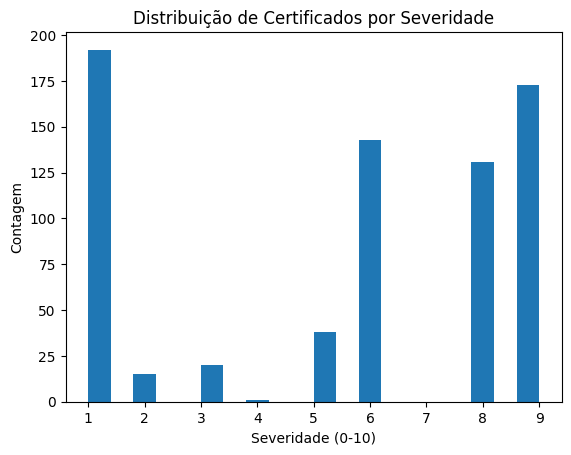

In [787]:
fig, ax = plt.subplots()
ax.hist(series['mapeamento_severidade'], bins=20)

ax.set(title='Distribuição de Certificados por Severidade',
           xlabel='Severidade (0-10)',
           ylabel='Contagem')
plt.show();

Podemos ver que os filmes são bem direcionados com relação a severidade do conteúdo, como na alta quantidade de filmes com severidade baixa, média ou alta, Não tendo quantidade relevante em classificação média-baixa, por exemplo.

- Destaca-se que todo filme tem o nível de severidade bem definido, feitos para o mundo e não apenas para se adequar a algum continente ou país específico.

Pensando nas estrelas dos filmes, podemos agrupar e ver quais atores e atrizes, possuem alta frequëncia em filmes com alto faturamento:

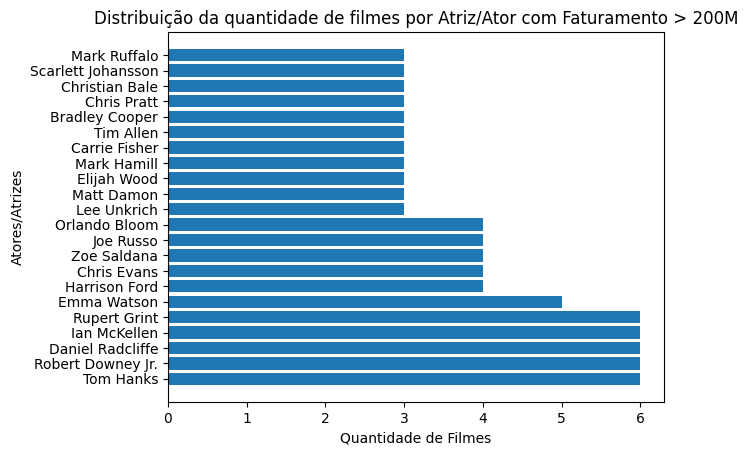

In [815]:
acima_200M = series[series['gross'] > 200000000]
stars_acima_200M = pd.melt(acima_200M, value_vars=['star1','star2','star3','star4'], value_name='star')['star']
top_stars = stars_acima_200M.value_counts()[stars_acima_200M.value_counts() > 2]

fig, ax = plt.subplots()
ax.barh(top_stars.index, top_stars.values)
ax.set(title='Distribuição da quantidade de filmes por Atriz/Ator com Faturamento > 200M',
        xlabel='Quantidade de Filmes',
        ylabel='Atores/Atrizes')
plt.show();

Vemos que há atores de extremo destaque com 5+ participações em filmes de grande faturamento, sendo necessário analisar valores de cachê, interesse e disponibilidade, tornando a escolha crucial para o sucesso do filme. 

Terminando a Univariate Exploration, é interessante analisar a relação dos diretores com o faturamento:

Eliminando o fator outlier, filtraremos a partir da primeira prateleira de sucesso de faturamento (200 milhões) e participação em mais de 1 filme dessa pratileira:

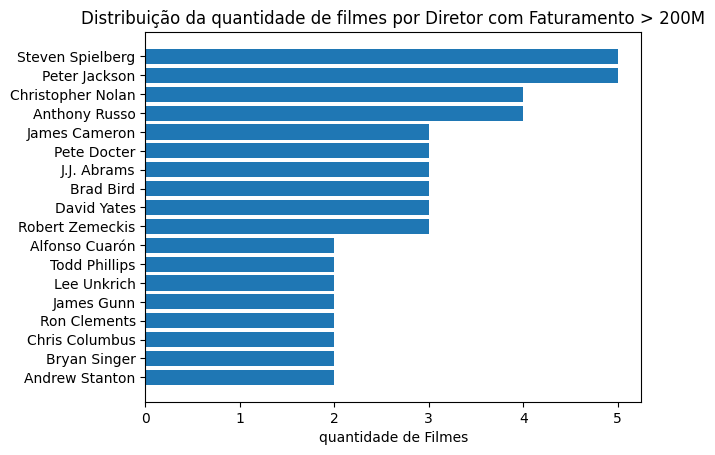

In [ ]:
fig, ax = plt.subplots()
acima_200M = series[series['gross'] > 200000000]
contagem_diretor = acima_200M['director'].value_counts()
multiplos_filmes = contagem_diretor[contagem_diretor > 1]
multiplos_filmes = multiplos_filmes.sort_values()

ax.barh(multiplos_filmes.index, multiplos_filmes.values)

ax.set(title='Distribuição da quantidade de filmes por Diretor com Faturamento > 200M',
             xlabel='quantidade de Filmes',
             ylabel='Diretor')
plt.show();

## 4. Bivariate Exploration


Iniciando a exploração bivariada:


Podemos começar analisando a distribuição de genero dentre as series com maiores ratings:

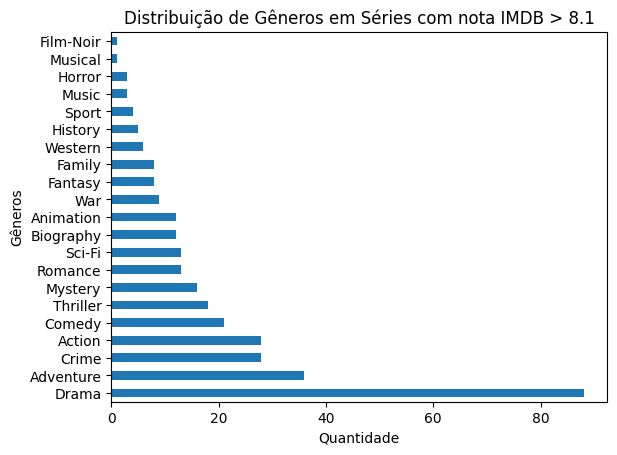

In [816]:
fig, ax = plt.subplots()
acima_8_1 = series[series['imdb_rating'] > 8.1]

generos_individuais = acima_8_1['genre'].str.split(', ').explode()

ax = generos_individuais.value_counts().plot.barh()
ax.set(title='Distribuição de Gêneros em Séries com nota IMDB > 8.1',
       xlabel='Quantidade',     
       ylabel='Gêneros')
plt.show();

Vemos que a aclamação do público geral é voltada para filmes de **drama**, além de algumas categorias que também se destacam como
- aventura
- crime
- Ação

Aprofundado sob os filmes de maior rating (>8.6), podemos ver algumas combinações que vão bem em conjunto:

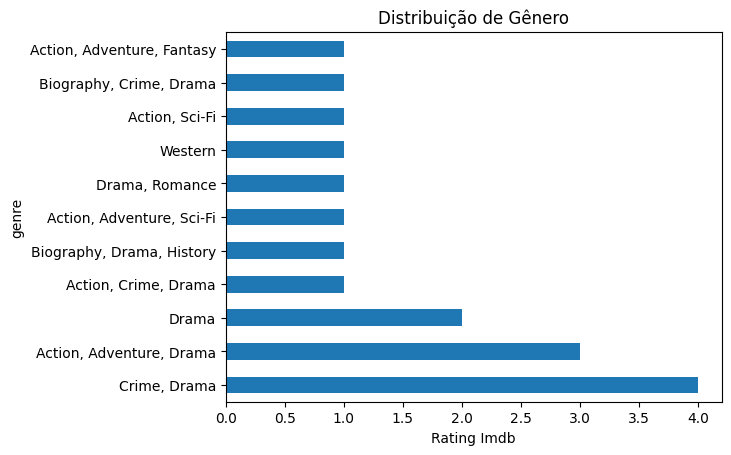

In [820]:
fig, ax = plt.subplots()

acima_8_6 = series[series['imdb_rating'] > 8.6]

ax = acima_8_6.genre.value_counts().plot.barh()

ax.set(title='Distribuição de Gênero',
            xlabel='Rating Imdb'
            )

plt.show();

Com este gráfico podemos destacar a força dos filmes de drama e combinações de destaque como:
- Crime, Drama
- Ação, aventura e drama 

Além do drama sozinho, que também conquista espaço entre as series de maior rating.

Sobre a influência do rating_imdb no faturamento:

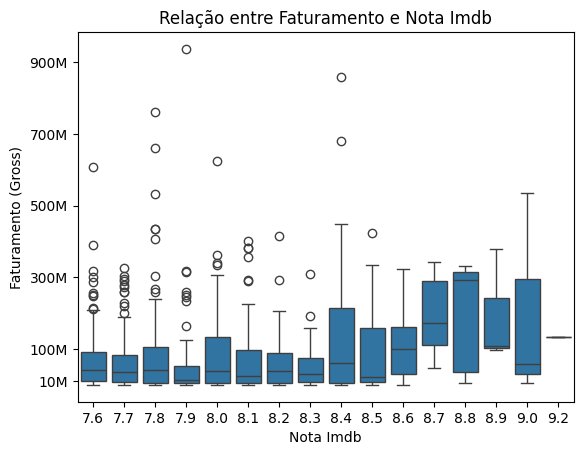

In [792]:
fig, ax = plt.subplots()

sns.boxplot(x='imdb_rating', y='gross', data=series)

ax.set(title='Relação entre Faturamento e Nota Imdb',
        ylabel='Faturamento (Gross)',
        xlabel='Nota Imdb')

y_ticks_positions = [10000000, 100000000, 300000000, 500000000, 700000000, 900000000]

ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(['10M', '100M', '300M', '500M', '700M', '900M'])

plt.show()



Analisando esta boxplot, entendemos que o rating do imdb tem influência média em relação ao faturamento, existindo series com valores acima de 900 Milhões mas nota 7.9

Mas series com notas acima de 8.3, nota-se um aumento de perspectiva de faturamento médio com base nos dados

Avançando, podemos explorar a influência do gênero no faturamento total:

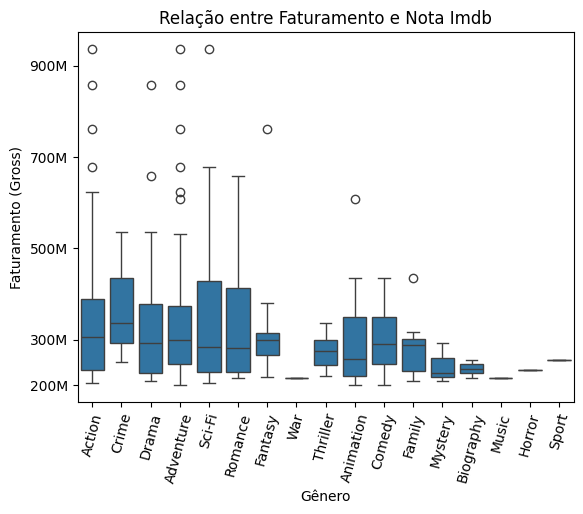

In [794]:
fig, ax = plt.subplots()

filtered_genres = series.assign(genre=series['genre'].str.split(', ')).explode('genre')
filtered_genres = filtered_genres[filtered_genres['gross'] > 200000000] 

sns.boxplot(x='genre', y='gross', data=filtered_genres)

ax.set(title='Relação entre Faturamento e Nota Imdb',
        ylabel='Faturamento (Gross)',
        xlabel='Gênero')

y_ticks_positions = [200000000, 300000000, 500000000, 700000000, 900000000]

ax.set_yticks(y_ticks_positions)
ax.set_yticklabels(['200M' ,'300M', '500M', '700M', '900M'])

plt.xticks(rotation=75)
plt.show()


Interessante ver que o Gênero tem boa relevância no faturamento do filme, com categorias destaques em outliers, como Action e Adventure com mais de 2 filmes com faturamento maior que 700 Milhões.

Entendemos que o número de votos tem grande influência em aspectos fundamentais no sucesso de um filme. Com isso, podemos analisar sua relação direta com o faturamento:

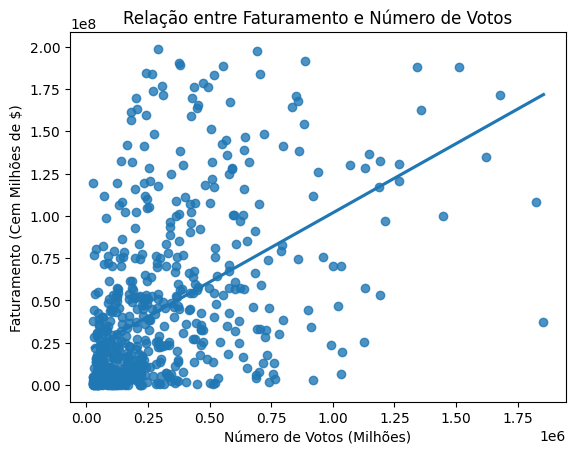

In [809]:
fig, ax = plt.subplots()
filtered_gross = series[series['gross'] < 200000000]

sns.regplot(data=filtered_gross, x="no_of_votes", y="gross", ci=None)

ax.set(title='Relação entre Faturamento e Número de Votos',
       xlabel='Número de Votos (Milhões)',
       ylabel='Faturamento (Cem Milhões de $)')
plt.show();

Eliminando os pontos de outliers (filmes acima de 200 Milhões), podemos enxergar que a relação entre número de votos e faturamento têm mais influência em filmes de média-baixa renda.

### 4.1 Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 
O faturamento de um filme é relativo, itens como rating do Imdb possuem baixa influência como um todo, mas em ratings altos é possível notar um aumento na renda. 

Além disso outros pontos como o número de votos ou gênero tem sua própria influência no resultado final sobre opinião pública e faturamento. Com isso é possível afirmar que existem diversos fatores que influenciam de diversas formas, por isso é importante manter o alto detalhamento e análises profundas para conseguir equilibrar a melhor escolha em cada campo.

## 5. Multivariate Exploration

Entrando na última exploração.

Inicialmente, vamos criar um fator para a análise multivariada, assumindo o faturamento como principal métrica de sucesso.

In [811]:
def faixa_gross(x):
    if x < 200000000:
        return 'Médio'
    else:
        return 'Alto'

series['hue_gross'] = series['gross'].apply(faixa_gross)

Analisar um mapa de calor das principais relações, também é um ótimo começo:

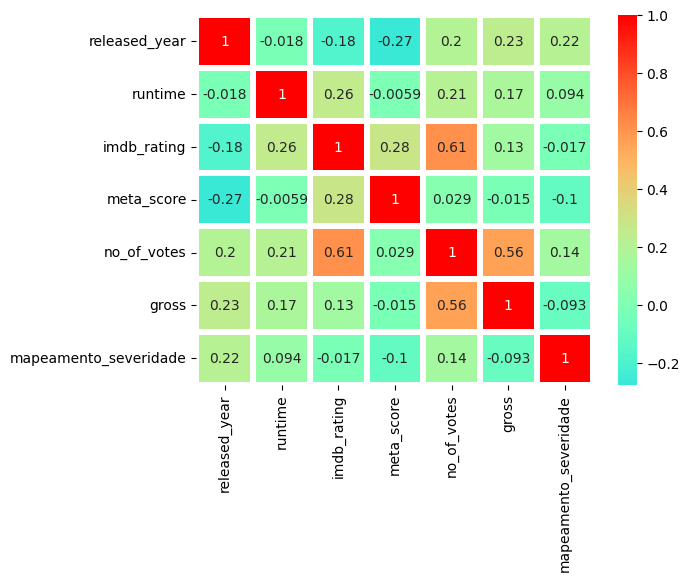

In [812]:
sns.heatmap(series.corr(numeric_only=True), annot=True, 
            linewidths=3, center=0, cmap='rainbow');

Se vê uma expectativa baixa em relação, por exemplo, ao rating imdb e faturamento com coeficiente r = 0.13 , mas deve-se ter cuidado, pois existem informações com influência direcionada, como o exemplo que possui correlação baixa, mas o retorno é visto apenas em filmes com rating > 8, influencia no topo, mas isso não é mostrado diretamente no mapa de calor.

Porém vemos alguns pontos a se observar em relação ao número de votos que tem boa correlação ao faturamento e imdb_rating

Após assumir nosso ponto de comparação e tirar algumas conclusões do mapa de calor, podemos iniciar as estatístivas

Primeiramente, podemos ligar o alto faturamento com o rating do imdb e faturamento total:

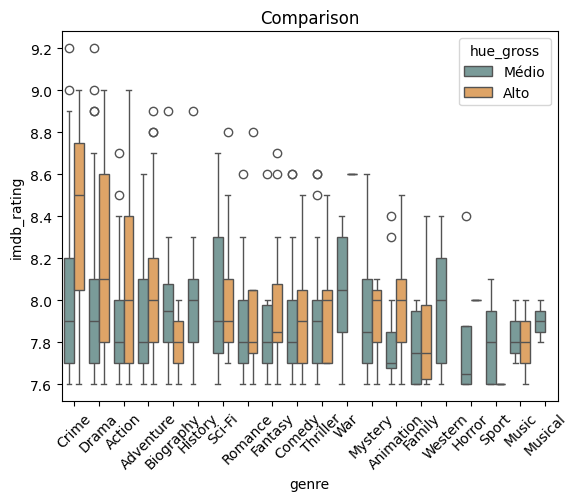

In [813]:

filtered_genres = series.assign(genre=series['genre'].str.split(', ')).explode('genre')
filtered_genres = filtered_genres[filtered_genres['gross'] > 50000000]

ax = sns.boxplot(x='genre', y='imdb_rating', data=filtered_genres, 
                 hue='hue_gross', palette=['#74a09e','#f2a553'])

ax.set(title='Comparison')
plt.xticks(rotation=45)

plt.show();

Nessa visão, entende-se que acompanhar o ritmo da categoria é fundamento. Onde ao escolher a categoria "Crime" ou "Drama", por exemplo, o rating do imdb (aceitação do público), influencia muito no faturamento. Mas em outros gêneros como em "adventure", o faturamento é influênciado por outros fatores, principalmente. 

Por outro lado, nota-se uma tendência, com excessões, que confirma o imdb_rating com influência média no faturamento

Outro ponto analisado, foi a influência do número de votos:

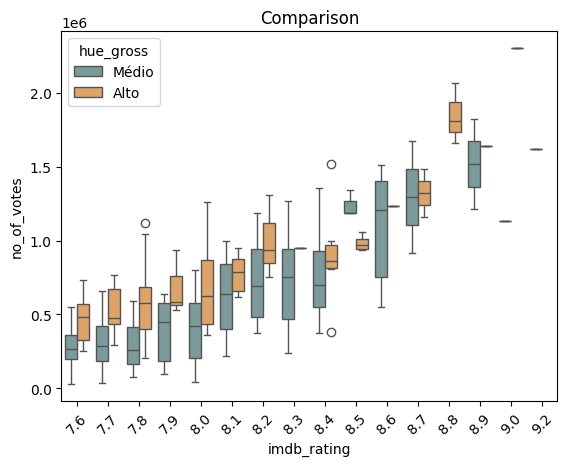

In [814]:
ax = sns.boxplot(x='imdb_rating', y='no_of_votes', data=series[series['gross'] > 50000000], 
                 hue='hue_gross', palette=['#74a09e','#f2a553'])

ax.set(title='Comparison')
plt.xticks(rotation=45)

plt.show();

Visualizamos que conforme a quantidade de votos aumenta, maior é o rating do imdb.

Além disso, nota-se que conforme o número de votos aumenta, o faturamento aumenta proporcionalmente, principalmente entre os ratings 7.6 até 8.4 onde só há aumentos de faturamento.
Assim comprovando a correlação de pearson entre as duas colunas no mapa de calor.

## 6. Conclusão

## MODELO DE PREVISÃO

- Problema de **regressão**, pois de acordo com os dados as métricas de sucesso de um filme se dão por imdb_rating e gross, principalmente afetados pelo número de votos
- As informações cedidadas ao modelo devem ter o imdb_rating e gross, tratado como excessão de dados de processamento, pois será o target

### Rascunhos de respostas para as perguntas
- Qual tipo de problema estamos resolvendo (regressão, classificação)?
- - Problema de **regressão**, pois de acordo com os dados, as métricas de sucesso de um filme se dão por imdb_rating e gross. Que originalmente são números.

- Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
- - Sim, com modelos de Machine Learning baseados em classificação como ....

- Qual modelo melhor se aproxima dos dados e quais seus prós e contras? 
- - - Compare os modelos e responda após completar toda a comparação

- Qual medida de performance do modelo foi escolhida e por quê?
- - De acordo com os dados e lógicas empresariais, as métricas de sucesso de um filme se dão por imdb_rating, que seria a nota dada pelo público e gross, resultado de boas escolhas e administração dos recursos bem executada.

